In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

tf.device('/physical_device:GPU:0')

In [2]:
INPUT_PATH = "./dataset/face-cut/train/"
INPUT_PATH_EVAL = "./dataset/face-cut/eval/"

In [3]:
#count image
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal train images are {total_images}")

total_images_test = 0
for dir_ in os.listdir(INPUT_PATH_EVAL):
    count = 0
    for f in os.listdir(INPUT_PATH_EVAL + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

negative has 799 number of images
neutral has 3547 number of images
positive has 5479 number of images

total train images are 9825
negative has 96 number of images
neutral has 441 number of images
positive has 676 number of images

total images are 11038


In [4]:
TOP_EMOTIONS = ["negative", "neutral", "positive"]

In [5]:
# store image and label into arrays
img_arr = np.empty(shape=(total_images,128,99,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
dim = (99, 128)
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_tmp = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_arr[i] = cv2.resize(img_tmp, dim, interpolation = cv2.INTER_AREA)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

for dir_ in os.listdir(INPUT_PATH_EVAL):
    if dir_ in TOP_EMOTIONS:
        for key, value in label_to_text.items():
            if dir_ == value:
                e = key
        for f in os.listdir(INPUT_PATH_EVAL + dir_ + "/"):
            img_tmp = cv2.imread(INPUT_PATH_EVAL + dir_ + "/" + f)
            img_arr[i] = cv2.resize(img_tmp, dim, interpolation = cv2.INTER_AREA)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")

img_arr.shape, img_label

loaded all negative images to numpy arrays
loaded all neutral images to numpy arrays
loaded all positive images to numpy arrays
loaded all negative images to numpy arrays
loaded all neutral images to numpy arrays
loaded all positive images to numpy arrays


((11038, 128, 99, 3), array([0., 0., 0., ..., 2., 2., 2.]))

In [6]:
label_to_text

{0: 'negative', 1: 'neutral', 2: 'positive'}

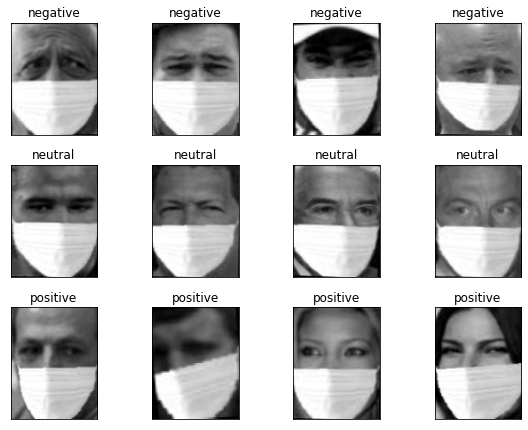

In [7]:
#randomly plot out images from each category
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()


In [8]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(11038, 3)

In [9]:
img_arr = img_arr / 255.

In [10]:
#splitting dataset to test data and train data
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9934, 128, 99, 3), (1104, 128, 99, 3), (9934, 3), (1104, 3))

In [11]:
del img_arr
del img_label

In [12]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]
img_width, img_height, img_depth, num_classes

(128, 99, 3, 3)

In [13]:
#load pre-trained model and modify it
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

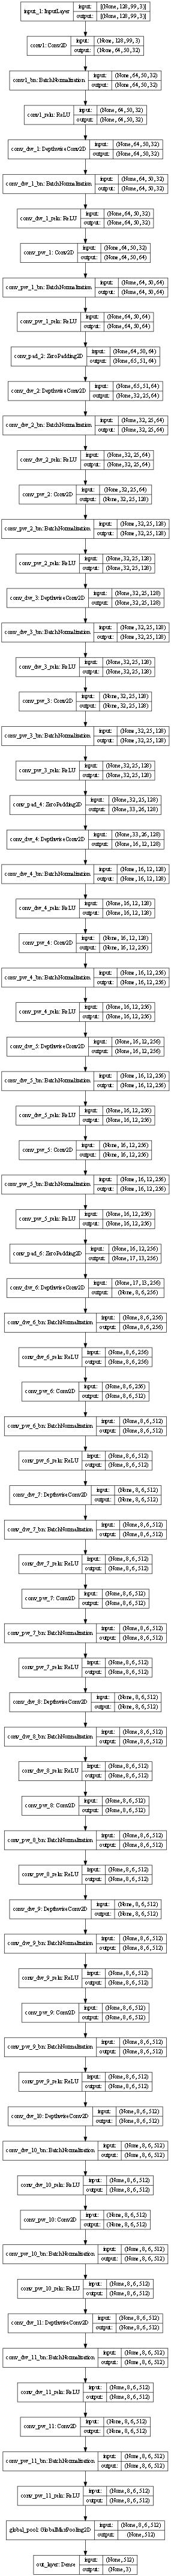

In [14]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

In [15]:
for layer in model.layers[:15]:
    layer.trainable = False

In [16]:
# generating tensor image data
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [17]:
#Configuring train options
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [18]:
#Start to train
batch_size = 25
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=False
)

Epoch 1/40
397/397 [==============================] - 80s 187ms/step - loss: 1.1868 - accuracy: 0.5633 - val_loss: 0.7440 - val_accuracy: 0.6712
Epoch 2/40
397/397 [==============================] - 73s 183ms/step - loss: 0.7923 - accuracy: 0.6590 - val_loss: 0.7731 - val_accuracy: 0.6558
Epoch 3/40
397/397 [==============================] - 75s 188ms/step - loss: 0.7188 - accuracy: 0.6937 - val_loss: 0.6764 - val_accuracy: 0.6748
Epoch 4/40
397/397 [==============================] - 75s 188ms/step - loss: 0.6798 - accuracy: 0.7080 - val_loss: 0.6987 - val_accuracy: 0.7092
Epoch 5/40
397/397 [==============================] - 77s 194ms/step - loss: 0.6671 - accuracy: 0.7082 - val_loss: 0.6457 - val_accuracy: 0.7346
Epoch 6/40
397/397 [==============================] - 76s 192ms/step - loss: 0.6375 - accuracy: 0.7208 - val_loss: 0.6711 - val_accuracy: 0.7219
Epoch 7/40
397/397 [==============================] - 75s 189ms/step - loss: 0.6366 - accuracy: 0.7213 - val_loss: 0.7413 - val_ac

In [19]:
#save model
model_yaml = model.to_yaml()
with open("model_mobelnet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_moblenet.h5")

C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warning

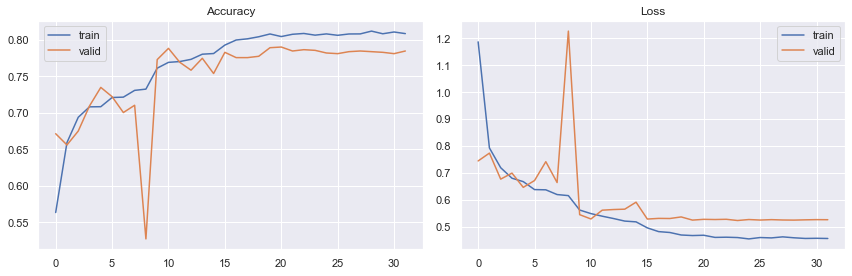

In [20]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

In [21]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'negative': 0, 'neutral': 1, 'positive': 2}

test accuracy: 78.9855 %


              precision    recall  f1-score   support

           0       0.71      0.47      0.57        89
           1       0.71      0.77      0.74       399
           2       0.85      0.85      0.85       616

    accuracy                           0.79      1104
   macro avg       0.76      0.70      0.72      1104
weighted avg       0.79      0.79      0.79      1104



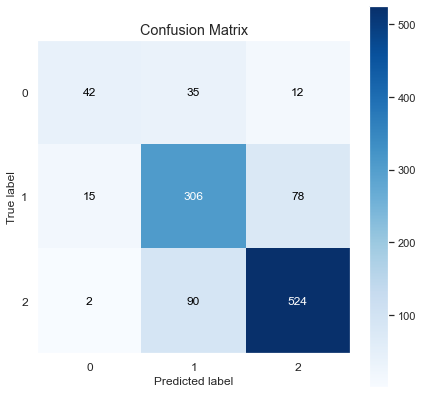

In [22]:
#Show test result
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

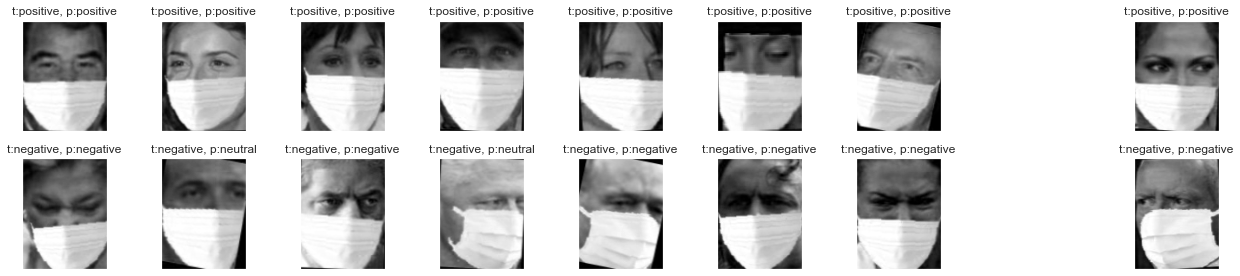

In [31]:
# randomly showing image and its predicted result
np.random.seed(42)
positive_imgs = np.random.choice(np.where(y_test[:, text_to_label["positive"]]==1)[0], size=9, replace=False)
negative_imgs = np.random.choice(np.where(y_test[:, text_to_label["negative"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(positive_imgs, negative_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:positive, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:negative, p:{pred}")

        pyplot.tight_layout()

In [33]:
# Show all missed class
def plot_miss_classified(emotion):
    miss_indices = np.where((ytest_ != yhat_test) & (ytest_==text_to_label[emotion]))[0]
    print(f"total {len(miss_indices)} miss labels out of {len(np.where(ytest_==text_to_label[emotion])[0])} for emotion {emotion}")

    cols = 15
    rows = math.ceil(len(miss_indices) / cols)
    fig = pyplot.figure(1, (20, rows * 2))

    for i,idx in enumerate(miss_indices):
        sample_img = X_test[idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(rows,cols,i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{pred}")    

total 92 miss labels out of 616 for emotion positive


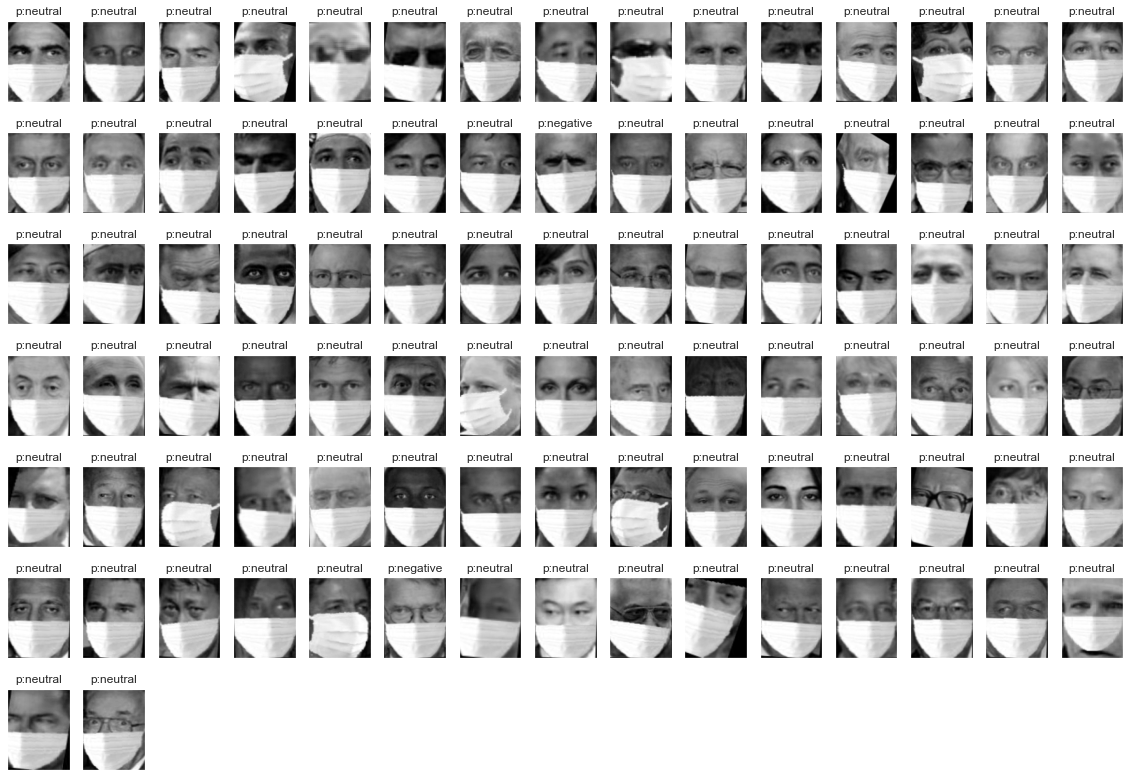

In [34]:
plot_miss_classified(emotion="positive")

total 47 miss labels out of 89 for emotion negative


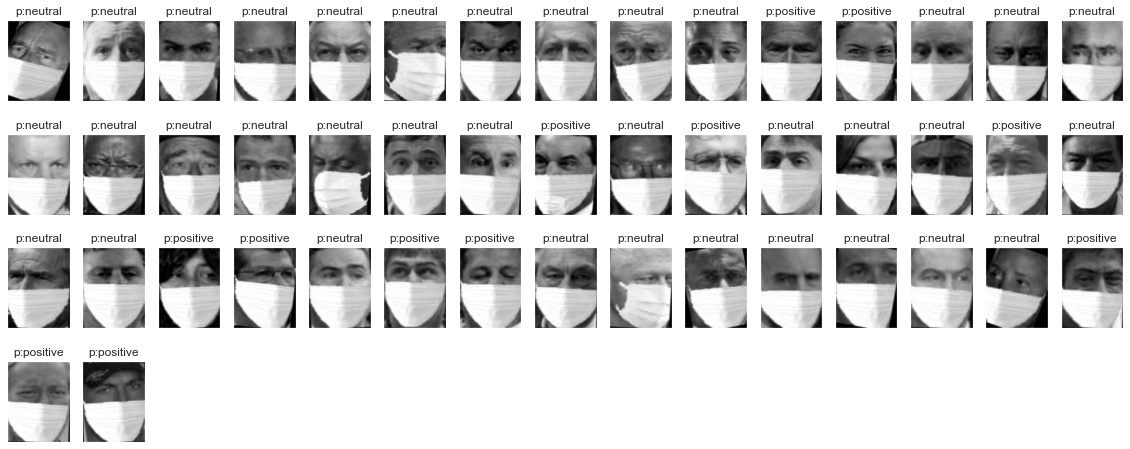

In [35]:
plot_miss_classified(emotion="negative")

total 93 miss labels out of 399 for emotion neutral


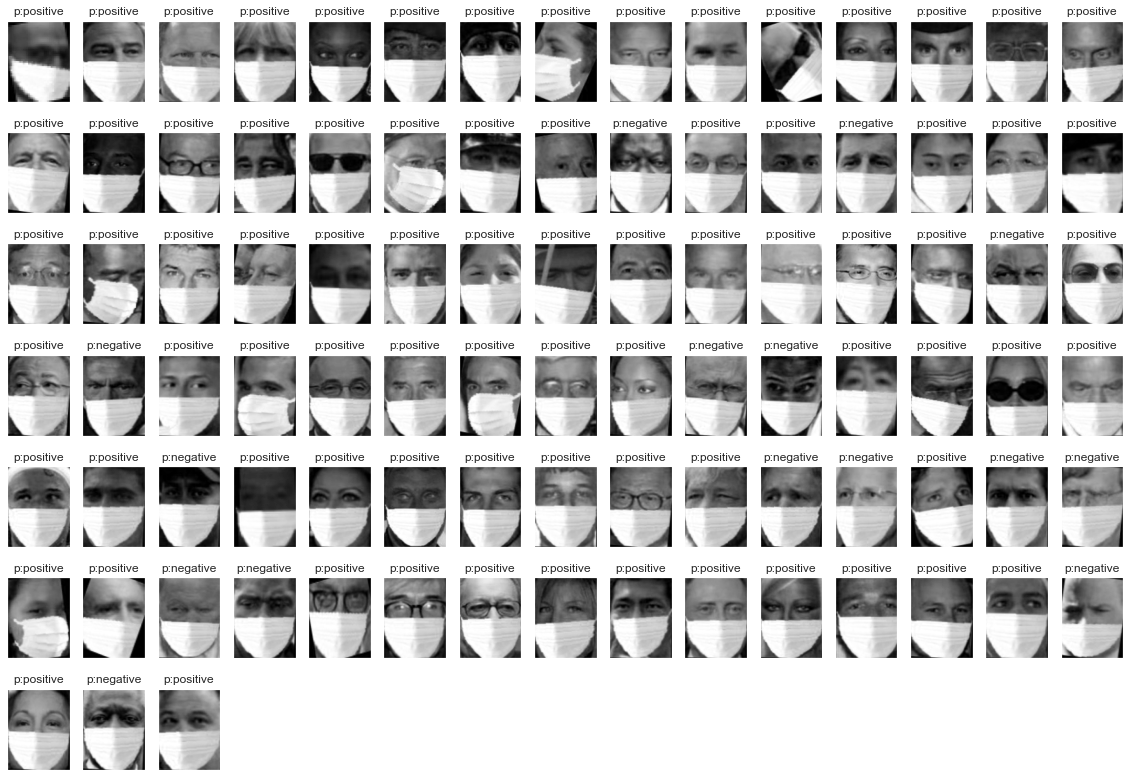

In [36]:
plot_miss_classified(emotion="neutral")